Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform
from sklearn.metrics import plot_confusion_matrix

def feature_finding(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08,0)
    bad = ['id','recorded_by','quantity_group','payment_type','source_type']
    X = X.drop(columns=bad)
    cols_with_zeros = ['longitude','latitude','construction_year',
                       'gps_height','population']
    for cols in cols_with_zeros:
        X[cols] = X[cols].replace(0, np.nan)
        X[cols+'_MISSING'] = X[cols].isnull()
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X = X.drop(columns='date_recorded')
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    return X

In [4]:
train, val = train_test_split(train, train_size=.8, test_size=.2,
                             stratify=train['status_group'], random_state=1)
train = feature_finding(train) 
val = feature_finding(val)
test = feature_finding(test)

In [5]:
target = 'status_group'
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = test

In [6]:
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(ce.OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        RandomForestClassifier(random_state=1, n_jobs=-1))
k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                        scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 5 folds: [0.80397727 0.80934343 0.80071549 0.79713805 0.80418771]


In [7]:
#pipeline
param = {'randomforestclassifier__n_estimators': range(50,500),
      'randomforestclassifier__max_depth':[5,10,15,20, None],
      'randomforestclassifier__max_features': uniform(0,1),
      'randomforestclassifier__min_samples_leaf': [1,10,100],}

randomized = RandomizedSearchCV(pipeline, param_distributions= param,
                                n_iter=50, cv=5, scoring='accuracy',
                                verbose=10, return_train_score=True,
                                n_jobs=-1)
randomized.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=1))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
        

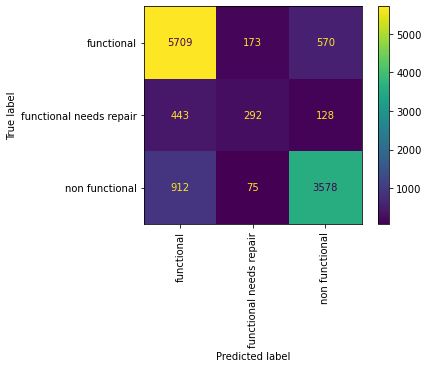

In [8]:
plot_confusion_matrix(randomized, X_val, y_val, values_format='.0f',
                     xticks_rotation='vertical');

In [9]:
y_pred = randomized.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('robbennettrandomizedforest2.csv', index=False)